In [2]:
import pandas as pd
import get_data as gd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from os import walk
import csv
from pychadwick.chadwick import Chadwick  
#https://github.com/jldbc/pybaseball
#https://baseballsavant.mlb.com/csv-docs
from pybaseball import statcast_pitcher
import seaborn as sns
from pybaseball import statcast
import statsmodels.api as sm

# Runs & Wins

The goal of any baseball team is to win as many games as you can, which you do by scoring more runs than you allow. Therefore like they say in MOneyball "Runs is the currency of winning". What this means is when you want to evaluating a player you don't need to neccessarily try and figure out how much they contribute to winning percentage, rather you can focus on how they contribute to runs scored/allowed and use that as a proxy.

The goal of this section is to explore the relationship between runs and wins.

## Getting & Cleaning the Data

We will use the Lahman dataset and only look at the relationship between runs and wins for teams in the 2000's. To do this we call the Teams.csv and filter to only records with a yearID of 2000 or more.

The next thing we need to do is calculate the Win Percentage (Wins divided by Games Played). We then calculate the average runs score and allowed per game.

In [3]:
teams_df = gd.make_df("Teams") 
teams_df = teams_df[teams_df['yearID'] >= 2000]
teams_df['Win Percentage'] = teams_df['W']/teams_df['G']
teams_df['Runs Per Game'] = teams_df['R']/teams_df['G']
teams_df['Runs Allowed Per Game'] = teams_df['RA']/teams_df['G'] 

## Looking at the Data

We graph a simple scatter plot of runs score and runs allowed vs win percentage, this gives us an idea of the correlation between each of these variable and win percentage.

As you would expect runs are positive correlated and runs allowed are negatively correlated. But does one matter more than the other?

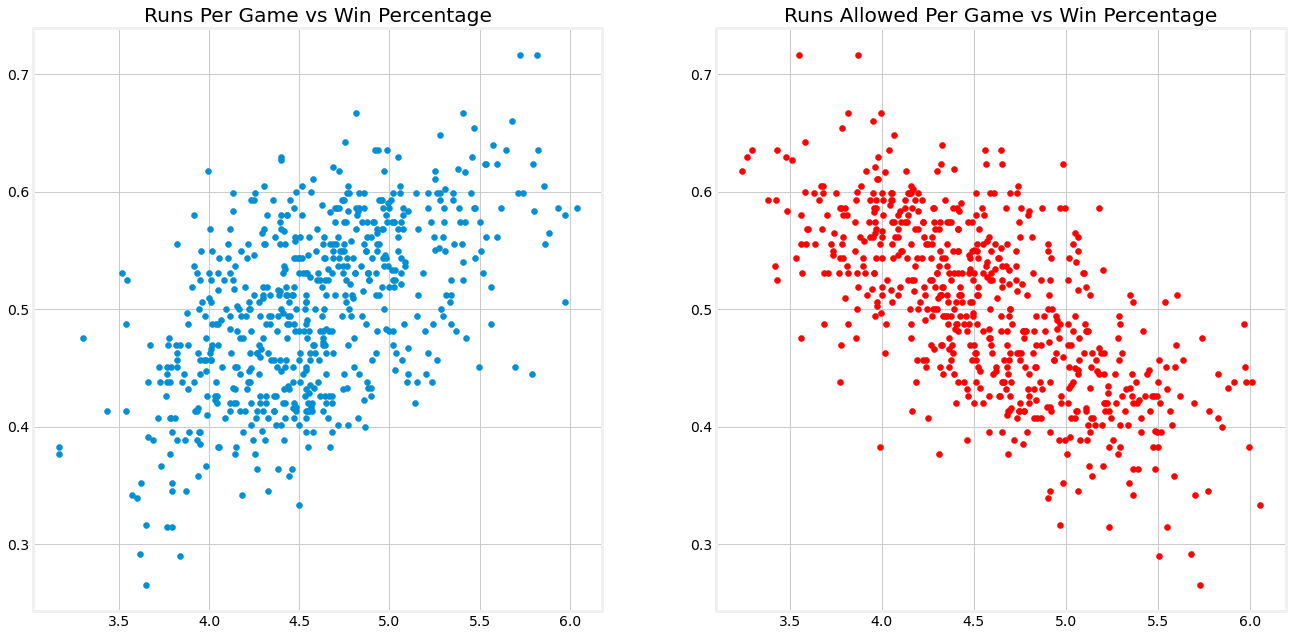

In [4]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,10))

gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax1.scatter(teams_df['Runs Per Game'], teams_df['Win Percentage'])
ax1.set_title('Runs Per Game vs Win Percentage')

fig.patch.set_facecolor('white')
ax2.set_facecolor('white')
ax2.scatter(teams_df['Runs Allowed Per Game'], teams_df['Win Percentage'], color='red')
ax2.set_title('Runs Allowed Per Game vs Win Percentage')
plt.show()

## First Method: OLS

The first method we use to look at the reltionship is running and Oridarny Least Squares (OLS). This model is simple and the easiest to understand. It will find the relationship between our independent variables (Runs and Runs Allowed) and dependent variable (Win Percentage) which gets the square or the errors as low as possible.

When you look at the coefficients you can read it as a one unit increase in that variable will result in that much of a change in the win percentage. So for example, an increae of 1 run per game for a team should result in an increase in their win percentage of 9.6% while an increase of 1 run allowed per game should decrease the win percentage by 10.2%. The confidence intervals give us the range of the coefficients we could reasonable expect.

A disadvantage of an OLS is it doesn't know that a win rate can't be higher than one or lower than zero. This will be something we tackle with the next method.

In [5]:
teams_df['Intercept'] = 1
full_model = sm.OLS(teams_df['Win Percentage'], 
                            teams_df[['Runs Per Game','Runs Allowed Per Game','Intercept']], hasconst=True).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Win Percentage   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     2322.
Date:                Sun, 04 Apr 2021   Prob (F-statistic):          1.39e-290
Time:                        11:16:18   Log-Likelihood:                 1420.2
No. Observations:                 630   AIC:                            -2834.
Df Residuals:                     627   BIC:                            -2821.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Runs Per Game             0.09

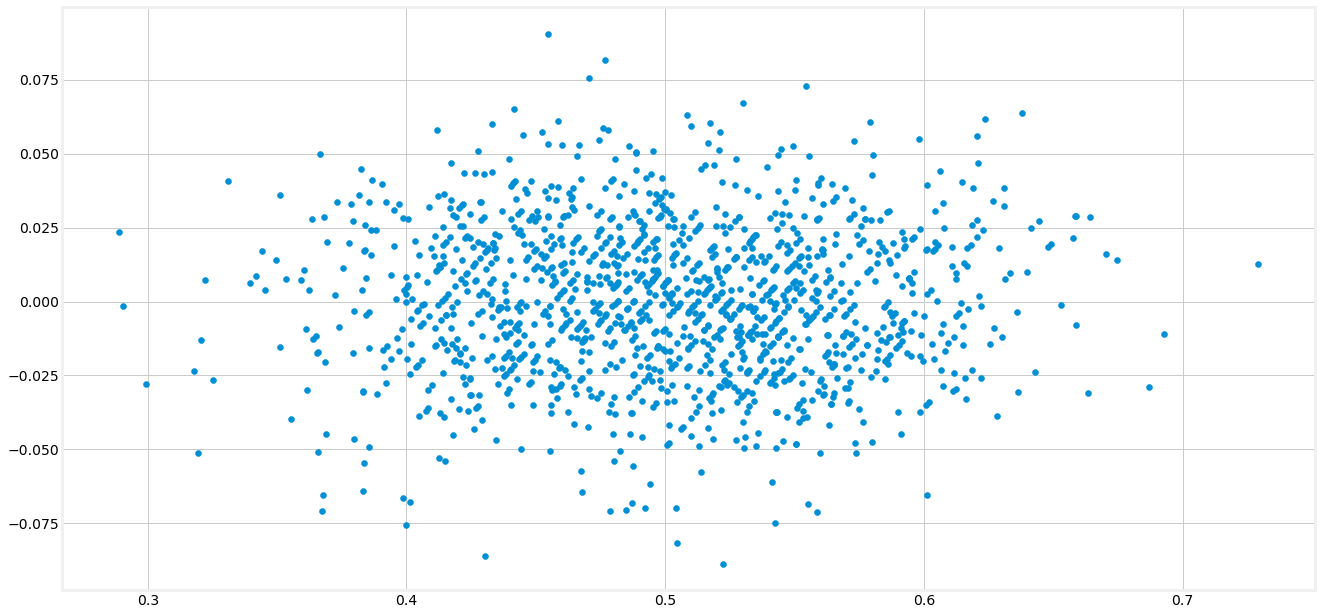

In [64]:
prediction = full_model.predict(teams_df[['Runs Per Game','Runs Allowed Per Game','Intercept']])
res = prediction - teams_df['Win Percentage']
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize= (20,10))
fig.patch.set_facecolor('white')
ax.scatter(prediction, res)
ax.set_facecolor('white')
#ax.set_xlim(0,100)
#ax.set_ylim(-20,20)

# Pythrongan Formula for Winning Percentage

Bill James developed an formula for estimating winning percentage which was R^2 / (R^2+RA^2)

In [65]:
import numpy as np
teams_df = teams_df[teams_df['yearID'] >=1970]
y = teams_df['Win Percentage']
teams_df['bill_james'] = teams_df['R']**2/(teams_df['R']**2 + teams_df['RA']**2)
X = teams_df['bill_james'] 

In [66]:
bill_james_model = sm.OLS(y, X).fit()
print(bill_james_model.summary())

                                 OLS Regression Results                                
Dep. Variable:         Win Percentage   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          5.376e+05
Date:                Sun, 04 Apr 2021   Prob (F-statistic):                        0.00
Time:                        08:59:24   Log-Likelihood:                          3162.7
No. Observations:                1414   AIC:                                     -6323.
Df Residuals:                    1413   BIC:                                     -6318.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

(0.0, 1.0)

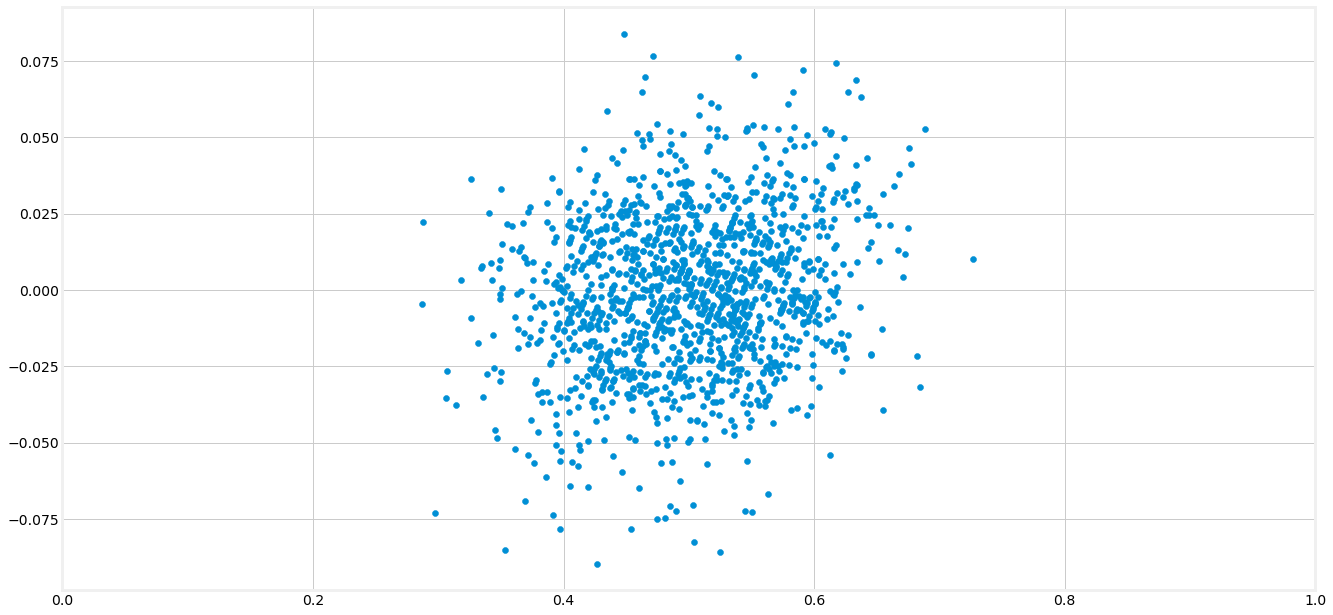

In [67]:
prediction = bill_james_model.predict(X)
res = prediction - y
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize= (20,10))
fig.patch.set_facecolor('white')
ax.scatter(prediction, res)
ax.set_facecolor('white')
ax.set_xlim(0,1)